In [28]:
import numpy as np
import re
from tqdm import tqdm
import math
from random import randint
 
vocab = set()
docs = []
 
D = 472 # number of documents
K = 10 # number of topics

# Read Data into Stuctures

In [31]:
# open each file; convert everything to lowercase and strip non-letter symbols; split into words
for fileind in range( 1, D+1 ):
    foo = open( 'files/output%04d.txt' % fileind ).read()    
    tmp = re.sub( '[^a-z ]+', ' ', foo.lower() ).split()
    docs.append( tmp )
 
    for w in tmp:
        vocab.add( w )
 
# vocab now has unique words
# give each word in the vocab a unique id
ind = 0
vhash = {}
vindhash = {}
for i in list(vocab):
    vhash[i] = ind
    vindhash[ind] = i
    ind += 1
 
# size of our vocabulary
V = ind
 
# reprocess each document and re-represent it as a list of word ids

docs_i = []

for d in docs:
    dinds = []
    for w in d:
        dinds.append( vhash[w] )
    docs_i.append( dinds )


# Full LDA 

In [38]:
''' Creates a matrix of size [D, V] i.e Documents and Vocabulary'''
''' Indexing q[i][j] will give you doc i's and word j's topic assigment'''
''' Randoming assign each word for each document a random K (0 to K-1) topic'''
def randomly_assign_topics():
    qs = []
    c = np.zeros((D, V, K))
    for i in xrange(D):
        qs_i = []
        for l, hash_i in enumerate(docs_i[i]):
            k = randint(0, K-1)
            qs_i.append(k)
            c[i][hash_i][k] += 1
        qs.append(qs_i)
    
    return qs, c

                       
def compute_data_likelihood(qs, topics):
    likelihood = 0
    for i in xrange(D):
        for l, hash_i in enumerate(docs_i[i]):
            k = qs[i][l]
            likelihood += math.log(topics[hash_i][k])
    return likelihood

def resample_qs(qs, c_vk, c_ik):
    for i in xrange(D):
        for l, hash_i in enumerate(docs_i[i]):
            prob_dist = []
            total = 0
            for k in xrange(K):
                prob = pdtm[k][i] * topics[hash_i][k]
                total += prob
                prob_dist.append(prob)
            prob_dist = np.asarray(prob_dist) / total
            
            '''Resample new topic for word'''
            new_k = np.random.choice(K, p=prob_dist)
            '''Assign new k to work in document'''
            old_k = qs[i][l]
            qs[i][l] = new_k

            '''Update counts c_vk'''
            c_vk[hash_i][old_k] -=1
            c_vk[hash_i][new_k] +=1
            '''Update counts c_ik'''
            c_ik[i][old_k] -=1
            c_ik[i][new_k] +=1
                
    return qs, c_vk, c_ik


'''[Q], [c]'''
qs, c = randomly_assign_topics() #(472, 17675) 

'''Collect statistics'''
c_vk = np.sum(c, axis=0) #(17675, 10)
c_ik = np.sum(c, axis=1) #(472, 10)
c_k = np.sum(c_vk, axis=0) #(10,)
L_i = np.sum(c_ik, axis=1) #(472,) 

'''[alpha] [beta] hyperparameters'''
alphas = np.ones((K,1))[:,0]
gammas = np.ones((V,1))[:,0]

'''[PI] For each document, dirichlet distribution over topics'''
# per-document-topic distributions: 
pdtm = np.zeros((K,D)) 
for i in xrange(D):
    pdtm[:,i] = np.random.dirichlet(alphas + c_ik[i])

'''[B] For each topic, dirichlet distribution over words/vocab'''
# topic distributions: 
topics = np.zeros((V,K))
for k in xrange(K):
    topics[:, k] =  np.random.dirichlet(gammas + c_vk[:,k])


full_gibbs_likelihoods = [] 
for iters in tqdm(range(0,100)):
    # compute data likelihood
    p = compute_data_likelihood(qs, topics)
    
    # store likelihood
    full_gibbs_likelihoods.append(p)
    
    #print "Iter %d, p=%.2f" % (iters,p)
    
    # resample per-word topic assignments qs
    qs, c_vk, c_ik = resample_qs(qs, c_vk, c_ik)
 
    # resample per-document topic mixtures pdtm
    for i in xrange(D):
        pdtm[:,i] = np.random.dirichlet(alphas + c_ik[i])
        
    # resample topics
    for k in xrange(K):
        topics[:, k] = np.random.dirichlet(gammas + c_vk[:,k])
        
        

100%|██████████| 100/100 [1:00:31<00:00, 36.68s/it]


## Collapsed Gibbs Sampling for LDA

In [33]:
def resample_topic_collaspsed(qs, docs_i, c_vk, c_ik, c_k):
    for i in xrange(D):
        for l, hash_i in enumerate(docs_i[i]):
            total = 0
            prob_dist = []
            for k in xrange(K):
                prob = ((c_vk[hash_i][k] + 1) / (c_k[k] + V)) * ((c_ik[i][k] + 1) / (L_i[i] + K))
                total += prob
                prob_dist.append(prob)
            prob_dist = np.asarray(prob_dist) / total
            
            '''Resample new topic for word'''
            new_k = np.random.choice(K, p=prob_dist)
            '''Assign new k to work in document'''
            old_k = qs[i][l]
            qs[i][l] = new_k

            '''Update counts c_vk'''
            c_vk[hash_i][old_k] -=1
            c_vk[hash_i][new_k] +=1
            '''Update counts c_ik'''
            c_ik[i][old_k] -=1
            c_ik[i][new_k] +=1
            '''Update counts c_k'''
            c_k[old_k] -=1
            c_k[new_k] +=1
                
    return qs, c_vk, c_ik, c_k

qs, c = randomly_assign_topics() 

#collect statistics
c_vk = np.sum(c, axis=0) #(17675, 10)
c_ik = np.sum(c, axis=1) #(472, 10)
c_k = np.sum(c_vk, axis=0) #(10,)
L_i = np.sum(c_ik, axis=1) #(472,) #never changes

# topic distributions: 
topics_ = np.zeros((V,K))
for k in xrange(K):
    topics_[:, k] =  np.random.dirichlet(gammas + c_vk[:,k])

collapsed_gibbs_likelihoods = []
for iters in tqdm(range(0,100)):
    
    # compute data likelihood
    p = compute_data_likelihood(qs, topics_)
    
    #store likelihood
    collapsed_gibbs_likelihoods.append(p)
    
    print "Iter %d, p=%.2f" % (iters,p)
    
    # resample per-word topic assignments qs
    qs, c_vk, c_ik, c_k = resample_topic_collaspsed(qs, docs_i, c_vk, c_ik, c_k)
    
     # resample topics - just for the likelihood
    for k in xrange(K):
        topics_[:, k] =  np.random.dirichlet(np.ones(V) + c_vk[:,k])


  0%|          | 0/100 [00:00<?, ?it/s]

Iter 0, p=-5368253.94



Exception in thread Thread-7:
Traceback (most recent call last):
  File "/Users/Iris/anaconda/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/tqdm/_tqdm.py", line 103, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/Iris/anaconda/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


  1%|          | 1/100 [00:51<1:24:23, 51.15s/it]

Iter 1, p=-5331220.90



  2%|▏         | 2/100 [01:39<1:22:00, 50.21s/it]

Iter 2, p=-5311431.85



  3%|▎         | 3/100 [02:31<1:22:20, 50.93s/it]

Iter 3, p=-5297377.32



  4%|▍         | 4/100 [03:20<1:20:25, 50.26s/it]

Iter 4, p=-5285645.36



  5%|▌         | 5/100 [04:13<1:20:43, 50.98s/it]

Iter 5, p=-5275493.81



  6%|▌         | 6/100 [05:01<1:18:47, 50.30s/it]

Iter 6, p=-5264384.09



  7%|▋         | 7/100 [05:53<1:18:31, 50.66s/it]

Iter 7, p=-5255617.84



  8%|▊         | 8/100 [06:41<1:16:38, 49.98s/it]

Iter 8, p=-5243834.19



  9%|▉         | 9/100 [07:29<1:14:56, 49.41s/it]

Iter 9, p=-5229172.75



 10%|█         | 10/100 [08:23<1:16:06, 50.74s/it]

Iter 10, p=-5214907.68



 11%|█         | 11/100 [09:13<1:14:54, 50.50s/it]

Iter 11, p=-5200264.84



 12%|█▏        | 12/100 [10:01<1:13:00, 49.78s/it]

Iter 12, p=-5183605.29



 13%|█▎        | 13/100 [10:49<1:11:31, 49.33s/it]

Iter 13, p=-5165206.29



 14%|█▍        | 14/100 [11:38<1:10:18, 49.05s/it]

Iter 14, p=-5150622.36



 15%|█▌        | 15/100 [12:25<1:08:48, 48.57s/it]

Iter 15, p=-5137065.27



 16%|█▌        | 16/100 [13:14<1:07:52, 48.48s/it]

Iter 16, p=-5127154.35



 17%|█▋        | 17/100 [14:03<1:07:34, 48.85s/it]

Iter 17, p=-5121023.30



 18%|█▊        | 18/100 [14:53<1:06:55, 48.96s/it]

Iter 18, p=-5117921.88



 19%|█▉        | 19/100 [15:46<1:07:57, 50.34s/it]

Iter 19, p=-5117312.19



 20%|██        | 20/100 [16:35<1:06:22, 49.78s/it]

Iter 20, p=-5120664.65



 21%|██        | 21/100 [17:23<1:05:05, 49.43s/it]

Iter 21, p=-5121540.49



 22%|██▏       | 22/100 [18:11<1:03:48, 49.09s/it]

Iter 22, p=-5121901.96



 23%|██▎       | 23/100 [19:00<1:02:47, 48.93s/it]

Iter 23, p=-5122442.49



 24%|██▍       | 24/100 [19:48<1:01:44, 48.74s/it]

Iter 24, p=-5122883.75



 25%|██▌       | 25/100 [20:38<1:01:07, 48.90s/it]

Iter 25, p=-5125561.96



 26%|██▌       | 26/100 [21:27<1:00:35, 49.13s/it]

Iter 26, p=-5128104.71



 27%|██▋       | 27/100 [22:13<58:31, 48.10s/it]  

Iter 27, p=-5130663.35



 28%|██▊       | 28/100 [22:56<55:57, 46.63s/it]

Iter 28, p=-5133628.21



 29%|██▉       | 29/100 [23:39<53:47, 45.46s/it]

Iter 29, p=-5135230.11



 30%|███       | 30/100 [24:22<52:10, 44.72s/it]

Iter 30, p=-5139371.51



 31%|███       | 31/100 [25:11<52:46, 45.89s/it]

Iter 31, p=-5141691.91



 32%|███▏      | 32/100 [25:59<52:43, 46.53s/it]

Iter 32, p=-5143820.32



 33%|███▎      | 33/100 [26:47<52:30, 47.02s/it]

Iter 33, p=-5147229.79



 34%|███▍      | 34/100 [27:35<52:18, 47.55s/it]

Iter 34, p=-5149402.56



 35%|███▌      | 35/100 [28:29<53:17, 49.20s/it]

Iter 35, p=-5152937.05



 36%|███▌      | 36/100 [29:18<52:42, 49.41s/it]

Iter 36, p=-5154935.41



 37%|███▋      | 37/100 [30:09<52:07, 49.65s/it]

Iter 37, p=-5158427.57



 38%|███▊      | 38/100 [30:58<51:12, 49.55s/it]

Iter 38, p=-5160927.88



 39%|███▉      | 39/100 [31:46<50:00, 49.20s/it]

Iter 39, p=-5163720.90



 40%|████      | 40/100 [32:35<48:58, 48.97s/it]

Iter 40, p=-5164950.48



 41%|████      | 41/100 [33:23<47:52, 48.68s/it]

Iter 41, p=-5166609.12



 42%|████▏     | 42/100 [34:11<46:46, 48.40s/it]

Iter 42, p=-5168460.57



 43%|████▎     | 43/100 [34:58<45:47, 48.20s/it]

Iter 43, p=-5167870.45



 44%|████▍     | 44/100 [35:47<45:07, 48.35s/it]

Iter 44, p=-5169142.30



 45%|████▌     | 45/100 [36:36<44:24, 48.44s/it]

Iter 45, p=-5171980.63



 46%|████▌     | 46/100 [37:25<43:46, 48.64s/it]

Iter 46, p=-5175458.57



 47%|████▋     | 47/100 [38:13<42:57, 48.64s/it]

Iter 47, p=-5179994.82



 48%|████▊     | 48/100 [39:02<42:05, 48.57s/it]

Iter 48, p=-5185009.32



 49%|████▉     | 49/100 [39:51<41:31, 48.85s/it]

Iter 49, p=-5190105.82



 50%|█████     | 50/100 [40:40<40:46, 48.94s/it]

Iter 50, p=-5194000.74



 51%|█████     | 51/100 [41:30<40:08, 49.16s/it]

Iter 51, p=-5197825.38



 52%|█████▏    | 52/100 [42:17<38:42, 48.39s/it]

Iter 52, p=-5200823.31



 53%|█████▎    | 53/100 [43:14<40:04, 51.15s/it]

Iter 53, p=-5204053.08



 54%|█████▍    | 54/100 [44:16<41:42, 54.40s/it]

Iter 54, p=-5206084.56



 55%|█████▌    | 55/100 [45:21<43:02, 57.39s/it]

Iter 55, p=-5208531.60



 56%|█████▌    | 56/100 [46:09<40:09, 54.76s/it]

Iter 56, p=-5209785.20



 57%|█████▋    | 57/100 [46:57<37:41, 52.58s/it]

Iter 57, p=-5210900.44



 58%|█████▊    | 58/100 [47:41<35:06, 50.16s/it]

Iter 58, p=-5212182.68



 59%|█████▉    | 59/100 [48:24<32:47, 47.98s/it]

Iter 59, p=-5212661.94



 60%|██████    | 60/100 [49:07<30:56, 46.41s/it]

Iter 60, p=-5212581.31



 61%|██████    | 61/100 [49:50<29:27, 45.32s/it]

Iter 61, p=-5212924.98



 62%|██████▏   | 62/100 [50:34<28:29, 44.98s/it]

Iter 62, p=-5213296.06



 63%|██████▎   | 63/100 [51:17<27:20, 44.33s/it]

Iter 63, p=-5212857.44



 64%|██████▍   | 64/100 [52:04<27:07, 45.22s/it]

Iter 64, p=-5212851.50



 65%|██████▌   | 65/100 [52:54<27:14, 46.71s/it]

Iter 65, p=-5212970.51



 66%|██████▌   | 66/100 [53:43<26:48, 47.31s/it]

Iter 66, p=-5213395.20



 67%|██████▋   | 67/100 [54:31<26:11, 47.63s/it]

Iter 67, p=-5213776.99



 68%|██████▊   | 68/100 [55:22<25:57, 48.67s/it]

Iter 68, p=-5212718.26



 69%|██████▉   | 69/100 [56:12<25:15, 48.88s/it]

Iter 69, p=-5211708.07



 70%|███████   | 70/100 [57:01<24:29, 48.99s/it]

Iter 70, p=-5210952.68



 71%|███████   | 71/100 [57:50<23:38, 48.92s/it]

Iter 71, p=-5212427.31



 72%|███████▏  | 72/100 [58:38<22:47, 48.83s/it]

Iter 72, p=-5212498.67



 73%|███████▎  | 73/100 [59:27<21:57, 48.78s/it]

Iter 73, p=-5212041.11



 74%|███████▍  | 74/100 [1:00:16<21:09, 48.82s/it]

Iter 74, p=-5212904.99



 75%|███████▌  | 75/100 [1:01:05<20:18, 48.76s/it]

Iter 75, p=-5212340.25



 76%|███████▌  | 76/100 [1:01:53<19:28, 48.71s/it]

Iter 76, p=-5213084.63



 77%|███████▋  | 77/100 [1:02:41<18:32, 48.38s/it]

Iter 77, p=-5213916.80



 78%|███████▊  | 78/100 [1:03:28<17:38, 48.11s/it]

Iter 78, p=-5215269.20



 79%|███████▉  | 79/100 [1:04:17<16:54, 48.31s/it]

Iter 79, p=-5216325.12



 80%|████████  | 80/100 [1:05:06<16:07, 48.38s/it]

Iter 80, p=-5216940.19



 81%|████████  | 81/100 [1:05:53<15:16, 48.25s/it]

Iter 81, p=-5217837.34



 82%|████████▏ | 82/100 [1:06:43<14:37, 48.75s/it]

Iter 82, p=-5220725.48



 83%|████████▎ | 83/100 [1:07:36<14:09, 49.97s/it]

Iter 83, p=-5223571.27



 84%|████████▍ | 84/100 [1:08:27<13:21, 50.09s/it]

Iter 84, p=-5226026.39



 85%|████████▌ | 85/100 [1:09:17<12:33, 50.25s/it]

Iter 85, p=-5228354.03



 86%|████████▌ | 86/100 [1:10:05<11:34, 49.57s/it]

Iter 86, p=-5230002.55



 87%|████████▋ | 87/100 [1:10:53<10:39, 49.19s/it]

Iter 87, p=-5231845.22



 88%|████████▊ | 88/100 [1:11:42<09:46, 48.87s/it]

Iter 88, p=-5234331.42



 89%|████████▉ | 89/100 [1:12:30<08:55, 48.65s/it]

Iter 89, p=-5237334.39



 90%|█████████ | 90/100 [1:13:23<08:21, 50.11s/it]

Iter 90, p=-5239122.10



 91%|█████████ | 91/100 [1:14:12<07:26, 49.64s/it]

Iter 91, p=-5240704.51



 92%|█████████▏| 92/100 [1:15:03<06:41, 50.13s/it]

Iter 92, p=-5241956.75



 93%|█████████▎| 93/100 [1:15:53<05:50, 50.06s/it]

Iter 93, p=-5242222.12



 94%|█████████▍| 94/100 [1:16:41<04:57, 49.51s/it]

Iter 94, p=-5243848.35



 95%|█████████▌| 95/100 [1:17:29<04:04, 48.93s/it]

Iter 95, p=-5244600.38



 96%|█████████▌| 96/100 [1:18:16<03:13, 48.47s/it]

Iter 96, p=-5245224.38



 97%|█████████▋| 97/100 [1:19:06<02:26, 48.76s/it]

Iter 97, p=-5245526.90



 98%|█████████▊| 98/100 [1:19:53<01:36, 48.43s/it]

Iter 98, p=-5245019.00



 99%|█████████▉| 99/100 [1:20:41<00:48, 48.20s/it]

Iter 99, p=-5245889.86



100%|██████████| 100/100 [1:21:29<00:00, 48.07s/it]


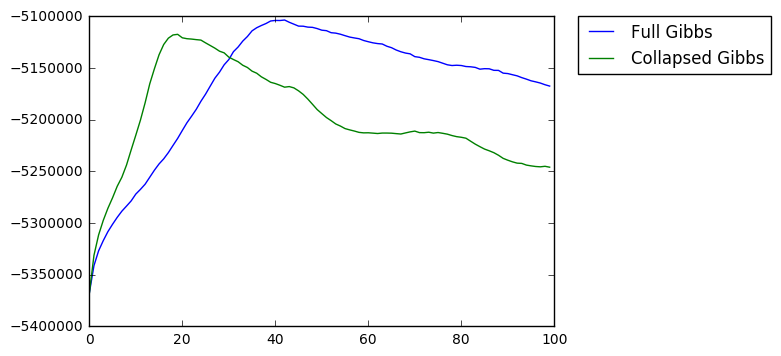

In [39]:
import matplotlib.pyplot as plt

plt.plot(range(100), full_gibbs_likelihoods, label='Full Gibbs')
plt.plot(range(100), collapsed_gibbs_likelihoods, label='Collapsed Gibbs')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

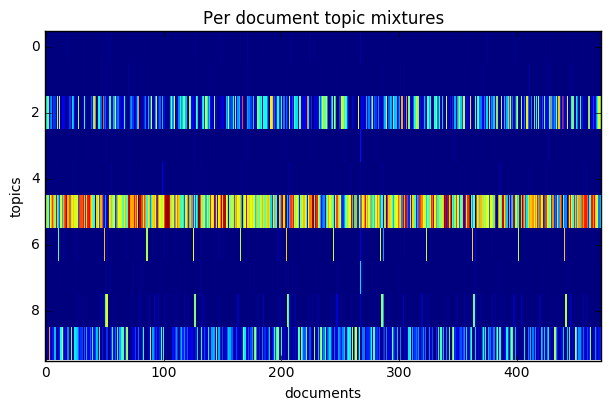

In [40]:
# Plotting my Per Document Topic Mixtures
plt.figure()
plt.imshow(pdtm, interpolation='nearest', cmap='jet', aspect='auto')
plt.title("Per document topic mixtures")

plt.tight_layout()
plt.ylabel('topics')
plt.xlabel('documents')
plt.show()
